<a href="https://colab.research.google.com/github/DiegoLeonG96/Tarea3_MLA/blob/main/Tarea_3_MLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 3 Machine Learning Avanzado

Integrantes:

- Julio Assmann
- Diego León
- Sofía Vits

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras import models, layers, optimizers, regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import kagglehub
# Establecer la semilla para Python
random.seed(42)

# Establecer la semilla para NumPy
np.random.seed(42)

# Establecer la semilla para TensorFlow
tf.random.set_seed(42)

## Introducción

## Metodología

## Modelos

### Autoencoder

#### Carga de datos

In [7]:
from google.colab import files
uploaded = files.upload()

Saving denoising-dirty-documents.zip to denoising-dirty-documents.zip


In [10]:
!unzip denoising-dirty-documents.zip
!unzip train.zip
!unzip test.zip

Archive:  denoising-dirty-documents.zip
replace sampleSubmission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  train.zip
   creating: train/
  inflating: train/101.png           
  inflating: train/102.png           
  inflating: train/104.png           
  inflating: train/105.png           
 extracting: train/107.png           
 extracting: train/108.png           
 extracting: train/11.png            
  inflating: train/110.png           
 extracting: train/111.png           
  inflating: train/113.png           
  inflating: train/114.png           
 extracting: train/116.png           
  inflating: train/117.png           
 extracting: train/119.png           
 extracting: train/12.png            
 extracting: train/120.png           
  inflating: train/122.png           
 extracting: train/123.png           
  inflating: train/125.png           
  inflating: train/126.png           
  inflating: train/128.png           
  inflating: train/129.png           
  inflating:

In [2]:
# Cargamos los datos
image_size=(420, 540)
X_train_ds = tf.keras.utils.image_dataset_from_directory(
    "train/",
    labels = None,
    image_size=image_size
)

X_test_ds = tf.keras.utils.image_dataset_from_directory(
    "test/",
    labels = None,
    image_size=image_size
)

X_train = []
for images in X_train_ds:
    X_train.append(images.numpy())

X_test = []
for images in X_test_ds:
    X_test.append(images.numpy())

# se cominan los datos en arreglos numpy
X_train = np.concatenate(X_train)
X_test = np.concatenate(X_test)

Found 144 files.
Found 72 files.


#### Exploración de datos

In [3]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (144, 420, 540, 3)
X_test shape: (72, 420, 540, 3)


Función para mostrar imágenes de ejemplo

In [4]:
def plot_images_in_grid(images, titles, n_examples=10, n_rows=2, figsize=(15, 5)):
    """
    Generaliza la creación de una grilla para mostrar imágenes.

    Parameters:
    - images: Lista de imágenes a mostrar.
    - titles: Lista de títulos para cada imagen.
    - n_examples: Número máximo de ejemplos a mostrar.
    - n_rows: Número de filas en la grilla.
    - figsize: Tamaño de la figura (tupla).
    """
    n_cols = (n_examples + n_rows - 1) // n_rows
    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Convertir ax a una lista, incluso si es un único objeto
    if n_rows == 1 or n_cols == 1:
        ax = np.array(ax).flatten()
    else:
        ax = ax.flatten()

    for idx in range(len(ax)):
        if idx < n_examples and idx < len(images):
            ax[idx].imshow(images[idx])
            ax[idx].set_title(titles[idx])
            ax[idx].axis('off')
        else:
            ax[idx].axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()


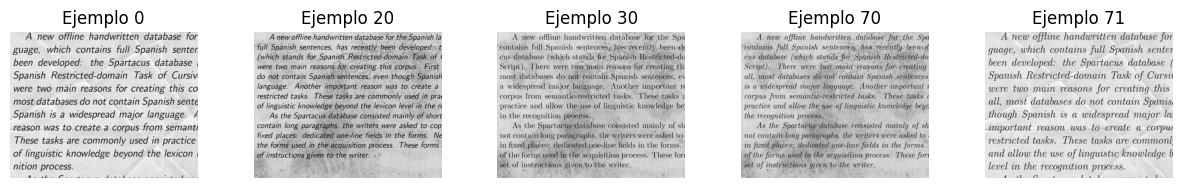

In [5]:
example_idx = [0, 20, 30, 70, 71]
filtered_images = [X_test[img_idx]/255 for img_idx in example_idx]
filtered_titles = [f'Ejemplo {img_idx}' for img_idx in example_idx]

plot_images_in_grid(filtered_images, filtered_titles, n_examples=len(filtered_images), n_rows=1)

#### Modelo autoencoder y entrenamiento

In [6]:
import cv2
X_train_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)[..., np.newaxis] for img in X_train])
X_test_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)[..., np.newaxis] for img in X_test])
X_train_scaled = X_train_gray/255
X_test_scaled = X_test_gray/255

In [16]:
from tensorflow.keras.layers import Cropping2D

class ConvAutoEncoder(Model):
    def __init__(self, input_shape):
        super().__init__()

        # Encoder
        self.encoder = Sequential([
            Input(shape=input_shape),
            Conv2D(16, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),

            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),

            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same')  # Representación comprimida
        ])

        # Decoder
        self.decoder = Sequential([
            Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
            UpSampling2D((2, 2)),

            Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
            Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            UpSampling2D((2, 2)),

            Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
            Conv2DTranspose(16, (3, 3), activation='relu', padding='same'),
            UpSampling2D((2, 2)),

            Cropping2D(cropping=((4, 0), (4, 0))),  # Ajusta dimensiones adicionales
            Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')  # Reconstrucción
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded




Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.1124 - mse: 0.1124 - val_loss: 0.0846 - val_mse: 0.0846
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - loss: 0.0810 - mse: 0.0810 - val_loss: 0.0470 - val_mse: 0.0470
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - loss: 0.0519 - mse: 0.0519 - val_loss: 0.0452 - val_mse: 0.0452
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 475ms/step - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0437 - val_mse: 0.0437
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 464ms/step - loss: 0.0462 - mse: 0.0462 - val_loss: 0.0445 - val_mse: 0.0445
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 483ms/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0430 - val_mse: 0.0430
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 470ms/step - loss: 0.0450 - mse: 0.0450 - val_loss: 0.0426 - val_mse: 0.0426
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 489ms/step - loss: 0.0444 - mse: 0

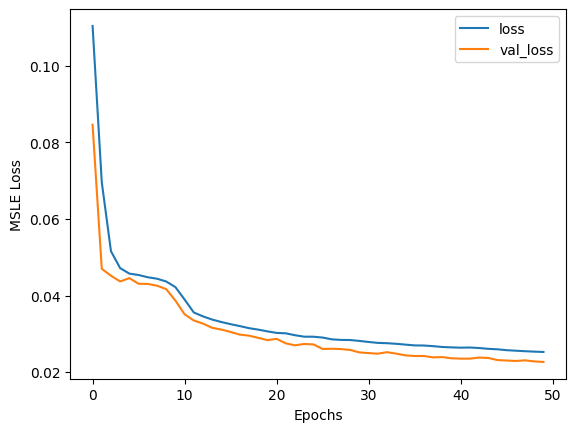

In [17]:
image_size=(420, 540)
model = ConvAutoEncoder(input_shape = (image_size[0], image_size[1], 1))
# configurations of model
lr = 1e-4
model.compile(loss='mean_squared_error', metrics =['mse'], optimizer = optimizers.Adam(learning_rate=lr))


history = model.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_scaled, X_test_scaled)
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
y_pred_ae = model.predict(X_test_scaled[0:5, :, :, :])
plt.imshow(y_pred_ae[0, :, :, :], cmap='gray')

### LSTM

## Análisis de resultados

## Conclusiones